Using device: cpu
total number of parameters of the network is: 49531
>>> loading ACCAD


<IPython.core.display.Javascript object>


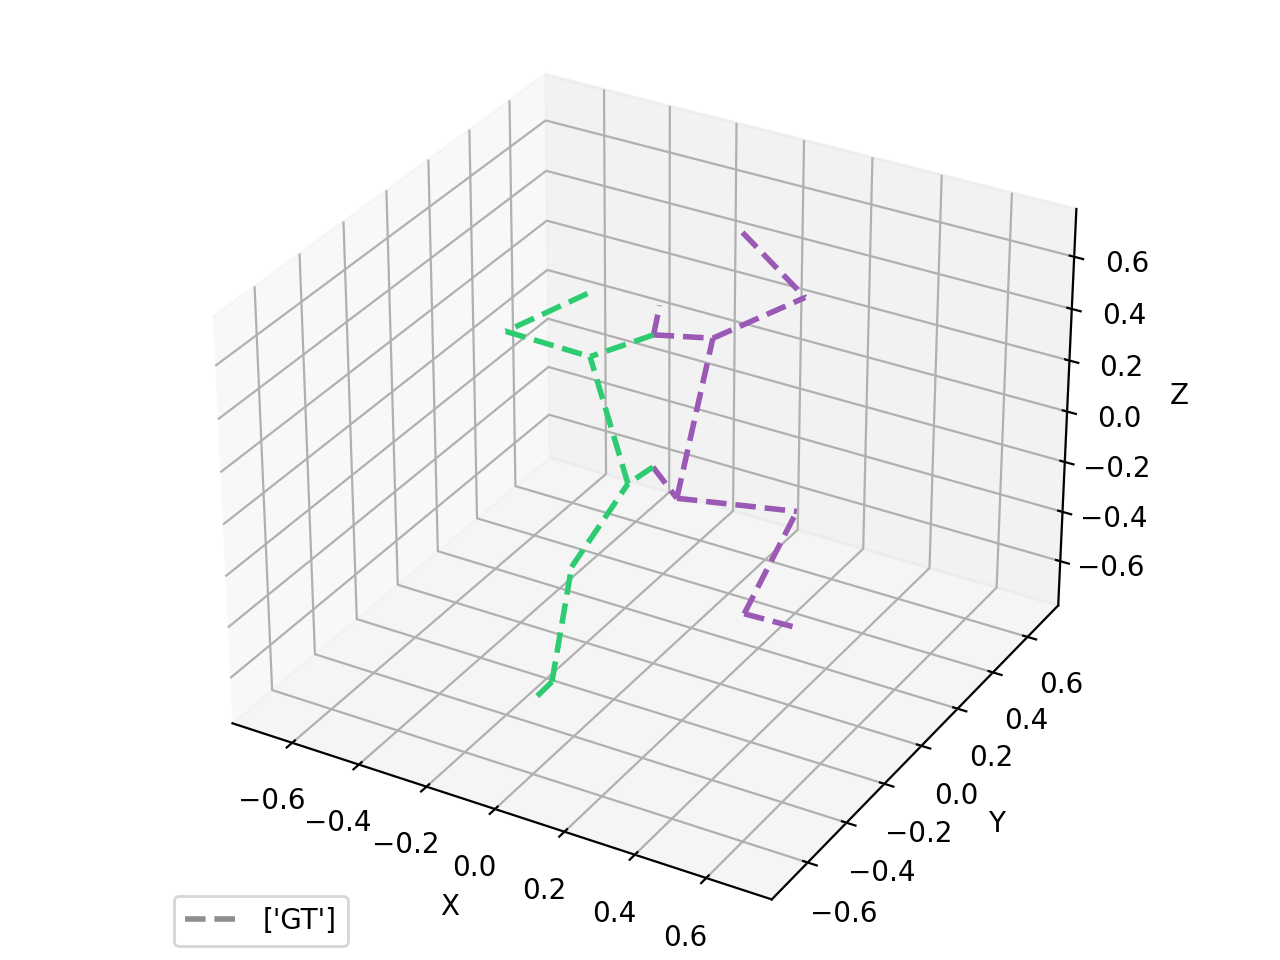

<ipython-input-4-e627279838be>:66: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/Users/arda/conda_root/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


In [4]:
%matplotlib notebook
import numpy as np
import sys
sys.path.insert(0, "../src")
import torch
from torch.utils.data import DataLoader
from utils.amass_3d_viz import create_pose, update
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from utils.config import read_config
from stsgcn.experiment_amass_3d import Amass3DExperiment
from stsgcn.experiment_h36_3d import H36_3DExperiment
from stsgcn.experiment_h36_ang import H36AngExperiment

dataset = 'amass_3d' # 'h36_ang', 'h36_3d'

path = "../datasets"
cfg = read_config("../configs/stsgcn_config.yaml")
body_model_dir = "../body_models/smpl_skeleton.npz"
cfg["body_model_dir"] = body_model_dir
input_n = cfg["input_n"]
output_n = cfg["output_n"]
visualize_from = cfg["visualize_from"]
data_dir = cfg["data_dir"]
n_viz = cfg["n_viz"]
visualize_from = 'train' # test, validation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if cfg["experiment"] == "amass_3d":
    from utils.amass_3d import Datasets
    experiment = Amass3DExperiment(cfg)
    skip_rate = experiment.skip_rate
    
    if visualize_from=='train':
        loader=Datasets(path,input_n,output_n,skip_rate,body_model_dir,device,split=0)
    elif visualize_from=='validation':
        loader=Datasets(path,input_n,output_n,skip_rate,body_model_dir,device,split=1)
    elif visualize_from=='test':
        loader=Datasets(path,input_n,output_n,skip_rate,body_model_dir,device,split=2)
        
    joint_used=np.arange(4,22)
    
    full_joint_used=np.arange(0,22)
        
    loader = DataLoader(
            loader,
            batch_size=1,
            shuffle = True,
            num_workers=0)

    for cnt, batch in enumerate(loader): 
        batch = batch.float().to(device) # multiply by 1000 for milimeters
        sequences_train = batch[:,0:input_n,joint_used,:].permute(0,3,1,2)
        sequences_predict_gt = batch[:,input_n:input_n+output_n,full_joint_used,:]
        
        sequences_predict = sequences_predict_gt.clone()
        
        all_joints_seq = sequences_predict_gt.clone()
        
        # all_joints_seq[:,:,joint_used,:] = sequences_predict

        data_gt = torch.squeeze(sequences_predict_gt,0).cpu().data.numpy()

        fig = plt.figure()
        ax = Axes3D(fig)
        vals = np.zeros((22, 3))
        gt_plots=[]

        gt_plots=create_pose(ax, gt_plots, vals,pred=False, update=False)

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.legend(loc='lower left')

        ax.set_xlim3d([-1, 1.5])
        ax.set_xlabel('X')

        ax.set_ylim3d([-1, 1.5])
        ax.set_ylabel('Y')

        ax.set_zlim3d([0.0, 1.5])
        ax.set_zlabel('Z')

        line_anim = animation.FuncAnimation(fig, update, output_n, fargs=(data_gt, data_gt, gt_plots, gt_plots, fig, ax), interval=70, blit=False)
        plt.show()
        break